## Neuroevolution DNA Sequence Comparison Using GA Trained Recurrent Neural Network
__October, 2018 - Christopher Sanchez__ 

A neuroevolution model will be created in order to compare DNA sequences. A genetic algorithm will be used to train a recurrent neural network to best determine similarity between sequences. The genetic algorithm will be utilized to determine the best weighting of the networks. The goal today is for the network to be effective at predicting similarity in order to infer homology.

Deoxyribonucleic acid, or DNA is a double helix shaped structure consisting of a chain of nucleotides known as basepairs that act like a blueprint, providing a list of instructions for your body to produce proteins. There are four distinct bases A, T, C and G. A always bonds with T and C always bonds with G. A wide variety of information can be gained from DNA analysis. It is possible to determine gender, disease susceptibility, familial ties, DNA is responsible for solving countless amounts of crime, and more! There are multiple sequencing techniques out there, but not all are great for common errors that can occur such as basepairs deletions and insertions. I was inspired by this paper: https://www.cse.unr.edu/~cheung/neorgene.pdf, to attempt improving the dna sequencing techniques that are used today. There will be two genes used today one for training which is LOCUS NT_187300, and is 156,246 base pairs long. The other gene that will be used for testing is LOCUS NT_187301 and is 177,312 basepairs long. A human genome consists of six billion basepairs mistakes are going to be made. It isn't uncommon for a basepair to get switched around. It is important to use a technique that can operate quickly and accurately. 

Genetic algorithms work by immitating Darwin's survival of the fittest theory. The survival of the fittest theory suggests that natural selection selects the best individuals and discards the weakest, thereby passing on only the strognest genes. Each sample is considered an individual. A population is all of the individuals together. A fitness score is used to determine how fit or weak an individual is. The best parents are used to breed and create individuals with characteristics of the parents. A mutation can be added to further improve on results. Finally evolution takes place combining all of the steps together to create the best offspring possible.

Combining recurrent neural networks and a genetic algorithm is a quite interesting way to train the network. First the dna sequence must be cleaned and processed in order to be passed into the neural network. Once the sequence is processed and split into individuals the genetic algorithm will pass the individuals into the neural network using mean squared error as the fitness score in order to provide a grade to each network. Then the data will be bred and mutated in order to produce offspring and cause evolution.

### Introduction:

To solve the problem of DNA sequence similarity comparison, two different splits of gene LOCUS NT_187300 will be taken and used for comparison to train the model. Basepairs are considered similar if the two genes being compared are the same. The dna sequence will be cleaned and processed to pass into a population of recurrent neural networks. The neural networks will be trained using a genetic algorithm to manipulate the weights from the weakest population based on previous high performing weights from the fittest population. The weights will be determined via crossover and mutation. Each neural network in the population will represent and individual. Al of the individuals will be trained using a training split, and tested using a test split. 

After the evolution of the population, the top network will be taken for further testing. It will be tested against four generated sequences with similarities of 0%, 33%, 66%, and 100%. These sequences will provide a good basis for how the model is performing. 

Finally as a validation test gene LOCUS NT_187301 will be imported and processed to further validate the effectiveness or uneffectiveness of the network.

In [1]:
import numpy as np
import pandas as pd
import re
import random
import time
from IPython.display import clear_output
from operator import add, sub
from numpy import argmax, array
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt
import keras
import tensorflow
# Import various componenets for model building
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Input, TimeDistributed, SimpleRNN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.stats import bernoulli
# Import the backend
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences


/Users/c/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/c/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Mean squared error sums the distance of all the points squared from the regression line fitting the data. Sklearns mean squared error function is used in order to generate the MSE which will be returned and utilized as the fitness score for the genetic algorithm. The data will also be reshaped into two dimensions from three in order to pass into the function properly.

In [2]:
def mse(y_true, y_pred):
    # reshape data in order to be passed into the mean squared error function
    y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
    #calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)
    return mse

The various sequences will be visualized using bargraphs. These two functions will allow for easy and clean displaying of the data. The first function plots one set of data, while the second function allows for comparisons between data.

In [3]:
def basepair_graph(data):
    # get a count of each basepair
    character_count = Counter(data)
    print(character_count)
    # create the labels and values
    labels, values = zip(*character_count.items())
    
    # create the index values
    indexes = np.arange(len(labels))
    # set the width of the bars
    width = .8
    
    # create bar plot
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0, labels)
    plt.title('Count of Basepairs')
    plt.xlabel('Basepairs')
    plt.ylabel('Count')
    plt.show()

def basepair_graph_comparison(sequence_one, sequence_two, width, ax=None):
    # get a count of each basepair for each sequence
    sequence_one_count = Counter(sequence_one)
    sequence_two_count = Counter(sequence_two)

    # create the labels and values
    labels_one, values_one = zip(*sequence_one_count.items())
    labels_two, values_two = zip(*sequence_two_count.items())

    # create the index values
    indexes = np.arange(len(labels_one))
    
    # create bar plot
    ax.bar(indexes, values_one, width);
    ax.bar(indexes, values_two, width * .5);


### I: Importing and analyzing data
LOCUS NT_187300 will be imported from a text file as a string. After it is imported it will be reassigned to the variable dna_basepairs. It will be cleaned by removing all of the numbers, new lines and white spaces. The sequence will then be visualized using the previously created basepair_graph function to demonstrate the distribution of the 156,246 basepairs.

Counter({'c': 44559, 'g': 42681, 'a': 36681, 't': 32325})


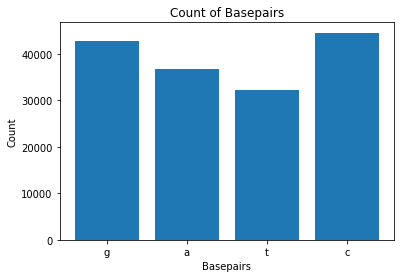

In [4]:
with open('dna.txt', 'r') as myfile:
  dna = myfile.read()
dna_basepairs = dna
dna_basepairs = re.sub(r'[0-9]([0-9])?([0-9])?([0-9])?([0-9])?([0-9])?', '', dna_basepairs)
dna_basepairs = re.sub(r'\n', '', dna_basepairs)
dna_basepairs = re.sub(r'\s+', '', dna_basepairs).strip()
dna_basepairs = dna_basepairs
# graph basepairs
basepair_graph(dna_basepairs)

It is a non normal and non uniform distribution. C's have the highest amount of basepairs at 44.5k. T's represent the lowest quantity at around 32.3k. 

### II: Processing the Dna Sequence into an array and determining similarity

The two sequences that need to be compared, and the split size are passed into the create_dna_array function. The amount of timesteps and samples are calculated in order to properly reshape the data to be passed into the neural networks. An array of zeroes is created to provide an array to be manipulated and allow for vectorization of the base pairs. The array will be shuffled to help prevent overfitting of the neural network. The two sequences will be vectorized and combined in order to be tested for similarity. Finally a similarity score will be awarded to each pair of sequences. 

In [5]:
def create_dna_array(sequence_one, sequence_two, batches):

    # determine number of samples to reshape the data into 3d
    samples = int(len(sequence_one) / batches)
    
    # Create an array of zeros to be filled with vectorized sequences
    array = np.zeros((len(sequence_one), 8))
    
    # mapping the array with a dictionary to effectively vectorize the basepairs.
    vectorize_sequence = {'a': 1, 't': 2, 'g': 3, 'c': 4}
    
    # for the bases in each sequence fill the designated spot in the array of zeroes with a 1.
    for base in range(len(sequence_one)):
        base_one = sequence_one[base]
        base_two = sequence_two[base]
        array[base, vectorize_sequence[base_one]] = 1
        array[base, vectorize_sequence[base_two] + 3] = 1
        
    # shuffle the array of vectorized sequences to help prevent overfitting
    np.random.shuffle(array)
    
    # determine whether sequences are similar or not and label true or false
    similarity_array = np.zeros((len(array), 1))

    for i in range(len(array)):
        if np.equal(array[i, :4], array[i, 4:]).all():
            similarity_array[i] == 1
        else:
            similarity_array[i] == 0 
            
    return [np.asarray(array).reshape(samples, batches, 8), 
            similarity_array.reshape(samples, batches, 1)]

### III: Creating the population of LSTM networks

30 LSTM networks, which will be considered the individuals in this test, will be created as the population. The network consists of three layers. The input layer, an LSTM layer, and a dense layer as the output layer. A tanh function will be used which will give an output between -0.9 and 0.9. 0.9 will be interpreted as having a very high similarity and -0.9 will be the inverse. Bias will also be used. 

In [6]:
def create_population(comparison, amount):
    network_population = []
    # create the specified amount of individual neural networks
    # using a tanh activation function
    for i in range(amount):
        model = Sequential()
        # add Long short term memory RNN layer using bias
        model.add(LSTM(8, 
                       input_shape=(comparison.shape[1], 8), 
                       activation='tanh', 
                       return_sequences=True, 
                       use_bias=True))
        
        # add a 10% dropout rate to help with overfitting
        #model.add(Dropout(0.1))

        # add a dense layer as the output layer using bias
        model.add(Dense(1, 
                        activation='tanh', 
                        use_bias=True))
        
        # append the individual to the population 
        network_population.append(model)
    return network_population

### IV: Grading the population:

The grading function is used to grade the fitness scores of the networks in order to sort the fittest networks from the weakest. For each individual in the population a prediction will be made using the individual network and scored using mean squared error. The networks will then be sorted using argsort. Finally the networks will be split into the nth fittest and weakest models. 

""" text is not updated because i have been changing the algorithm a lot trying to get it to work"""

In [7]:
def grade(pop, inputs, labels, split):
    # mse_vec stores the mean squared error score for each network in the population
    fitness = []
    for i in pop:
        # make a prediction with each individual
        y_pred = i.predict(inputs)
        # calculate mean squared error
        m_s_e = mse(y_pred, labels)
        # keep track of epochs
        fitness_score = 0
        y = []
        for layer in y_pred:
            for output in layer:
                y.append(output)
        for output in y:
            if (output >= 0.5) or (output <= -0.5):
                fitness_score += 1
        fitness.append((fitness_score, m_s_e, i))
    #fitness.sort(key=lambda tup: tup[0], reverse=True)
    fitness.sort(key=lambda tup:(-tup[0],tup[1]))

    graded_population = [individual[2] for individual in fitness]
    # set split to allow for various splits
    fittest = graded_population[:split]
    weakest = graded_population[split:]

    # separate the fittest networks from the weakest.
    fittest_models = []
    weakest_models = []
    for model in range(len(fittest)):
        fittest_models.append(pop[model])
    for model in range(len(weakest)):
        weakest_models.append(pop[model])
    return [fittest_models, weakest_models]

### V: Crossover and Mutate

In natural reproduction genes are passed on from parents to offspring. The crossover function is used to simulate this natural function. The fittest models will be bred, or crossed over to the weakest models, elimating some of the weaker genes with stronger genes. First the weights are retreived from the model being tested. Then a random bernoulli distribution will be generated at a predesignated rate. Next, the weights from the fittest individual, based on the position of 1's in the bernoulli distribution, will replace the weights in the weakest individual at the same position. Finally the new weights will be set and the crossover will have been completed.

In [8]:
def crossover(fittest, weakest, rate):
    # get weights
    fittest_weights = fittest.get_weights()
    weakest_weights = weakest.get_weights()

    # crossover the weights from the fittest networks to the weakest
    counter = 0
    for layer in weakest_weights:
        select_weights = bernoulli.rvs(p=rate, size=layer.shape)
        fit_weights = fittest_weights[counter]
        layer[select_weights==1] = fit_weights[select_weights==1] * select_weights[select_weights==1]
        counter += 1
    # set the new weights
    weakest.set_weights(weakest_weights)


Mutations naturally occur in the wild. They can be benficial or detrimental. There are some mutations that can cause immunity to certain diseases, and there are some mutations that cause diseases. The mutate function will be used to add some variation to the previous networks by randomly selecting weights from the individuals based on a bernoulli distribution and summing them with value from a generated gaussian distribution.

In [9]:
def mutate(fittest, weakest, rate):
    # get weights of the fittest and weakest networks
    fittest_weights = fittest.get_weights()
    weakest_weights = weakest.get_weights()

    # add a random value from a gaussian distributions to the previous weights
    for layer in fittest_weights:
        select_weights = bernoulli.rvs(p=rate, size=layer.shape)
        random_numbers = np.random.normal(0, 1, layer.shape)
        layer[select_weights==1] = random_numbers[select_weights==1] + layer[select_weights==1]
    for layer in weakest_weights:
        select_weights = bernoulli.rvs(p=rate, size=layer.shape)
        random_numbers = np.random.normal(0, 1, layer.shape)
        layer[select_weights==1] = random_numbers[select_weights==1] + layer[select_weights==1]
        
    # set the new weights
    fittest.set_weights(fittest_weights)
    weakest.set_weights(weakest_weights)


### VI Breeding

The breeding process is where everything starts to come to life. The crossover will be performed creating new child networks that will then be mutated. After they have been crossed over and mutated the population will be created using the new children.

In [10]:
def breed(fittest, weakest, rate):
    for weakest_model in weakest:
        weakest_model = np.random.choice(fittest)
        #choose random model to take weights from
        fittest_model = np.random.choice(fittest)
        #crossover weights
        #crossover(fittest_model, weakest_model, rate)
        # add or subtract weight from a gaussian distribution
        mutate(fittest_model, weakest_model, rate)    
        network_pop = fittest + weakest
    return network_pop

### VII: Evolve

Tying all of the stages together brings us to the evolution of the population. The training data will be imported and normalized. After the data is preprocessed it will be split into a training and testing set, with 30% being reserved for testing. During the first run the population of networks will be created to represent the individuals, and the model will allow for the variation of mutation and population split rates every 10 epochs. For 150 epochs the data will be passed into the grading function and the breeding function setting a new child population and tested against the test data. If the individual has a greater MSE than the previous run it will be added to the fittest population to be cycled back into the population. A list will also be created to graph the MSE across epochs. 

Total time to run: 0.9885000952084859 Top test MSE: 0.3657679963727796


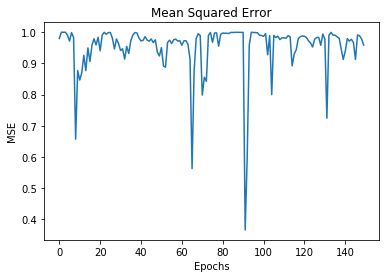

In [11]:
# set the network population to the original generated network population
network_population = []
graph_mse = []
mutate_rate = []
split_rate = []
fittest_population = {}
previous_mse = []
random_state = np.random.choice(np.arange(5, 40, 1))
total_time_start = time.time()
for run in range(1):
    start_run_time = time.time()

    # set mutation rate to 50% and split rate to the 10th index
    rate = 0.5
    split = 10
    # create the data shuffling it each run.
    comparison, similarity_array = create_dna_array(dna_basepairs[:150000], dna_basepairs[5000:155000], 50)
    comparison = keras.utils.normalize(comparison, axis=1, order=2)
    X_train, X_test, y_train, y_test = train_test_split(comparison, 
                                                        similarity_array, 
                                                        test_size=0.30, 
                                                        random_state=random_state)
    
    # create the initial population
    if run == 0:
        network_population = create_population(comparison, 30)
        #view the various lengths of the split data.
        print('Train length:', len(X_train), '\n', 'Test length:', len(X_test))
    else:
        pass
    
    # run 150 epochs
    for epoch in range(150):
        start_epoch_time = time.time()
        # grade the network population, breed it, and set the network population
        # to the new offspring
        grade_network = grade(network_population, X_train, y_train, split)
        breed_networks = breed(grade_network[0], grade_network[1], rate)
        network_population = breed_networks
        
        # add the top individuals score on the test data to a list for each epoch to be plotted
        y_pred = network_population[0].predict(X_test)
        m_s_e = mse(y_test, y_pred)
        
        # add MSE and individuals to dictionary for sorting
        if epoch == 0:
            fittest_population[m_s_e] = network_population[0]
            previous_mse = m_s_e
        elif m_s_e < previous_mse and epoch != 0:
            fittest_population[m_s_e] = network_population[0]
            previous_mse = m_s_e
        else:
            pass
        # sort the fittest individuals in reverse so when it is added to the population 
        # it is added in order
        fittest_population = OrderedDict(sorted(fittest_population.items(), 
                                                key=lambda t: t[0], 
                                                reverse=False))
        
        #insert the top population into the network population
        for individual in fittest_population.values():
            network_population.insert(0, individual)
            
        #reset the network population to the top 30 networks
        network_population = network_population[:29]

        # append mse score for graphing
        graph_mse.append(m_s_e)
        clear_output()
        
        # for the first run and every 10th epoch select a random mutation and split rate
        if run == 0 and epoch % 10 == 0:
            rate = np.random.choice(np.arange(0.1, 0.9, .1))
            split = np.random.choice(np.arange(5, 10, 1))
            mutate_rate.append(rate)
            split_rate.append(split)
        stop_epoch_time = time.time()
        epoch_duration = stop_epoch_time-start_epoch_time
        print('Run:', run + 1, 
              'Epoch:', epoch + 1, 
              'Time:', epoch_duration, 
              'Mean Squared Error:', m_s_e)
        # update the graph of MSE's for each epoch
        plt.plot(graph_mse)
        plt.title('Mean Squared Error')
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        plt.show()

    stop_run_time = time.time()
    run_duration = stop_run_time-start_run_time
    clear_output()
    print("Completed {} run(s):".format(run + 1), 'Time:', run_duration)
    
# At the end of running make sure the fittest individuals are in the top of the population
for individual in fittest_population.values():
            network_population.insert(0, individual)

y_pred = network_population[0].predict(X_test)
top_test = mse(y_test, y_pred)
clear_output()
total_time_end = time.time()
total_time = total_time_end-total_time_start
print('Total time to run:', (total_time / 60) / 60, 'Top test MSE:', previous_mse )

# graph the Mean Squared error of the top networks through each epoch.
plt.plot(graph_mse)
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()


"" Some text about how the graph looks and how the network performed "" 

The output of the best individual will be visualized for analysis. The graph should show a -9 output for disimilar basepair comparisons and 9 for similar comparisons.

0.38294402
Mean Squared Error: 0.9588982392020416


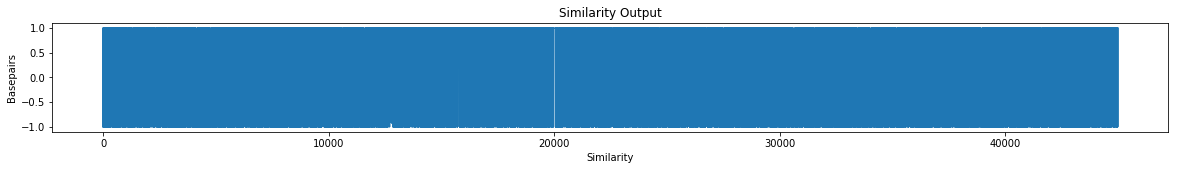

In [12]:
# run the best network on the test data to test for consistency.
y_pred = network_population[0].predict(X_test)
m_s_e = mse(y_test, y_pred)

print(y_pred.mean())
print('Mean Squared Error:', m_s_e)

# graph the output similarity of the top network.
plt.figure(figsize=(20,2))
plt.plot(y_pred.reshape(y_pred.shape[0]*y_pred.shape[1], 1))
plt.title('Similarity Output')
plt.xlabel('Similarity')
plt.ylabel('Basepairs')
plt.show()

""" text reflecting the networks performance """

### VIII: Creating sequences for testing.

In order to further test the network a function will be implemented to create sequences with a specified rate of similarity. Four sequences will then be created for testing. The first sequence will be completely the same. The function will match up basepairs at a rate of 100%. After that a sequence will be created to reflect a 33% rate of similarity. Next up is a sequence that's 66% similar. The final sequence will be completely different with a similarity of 0%.

In [13]:
def create_sequences(size, difference):
    sequence_one = []
    sequence_two = []
    # create same sequences
    if  difference == 0:       
        for x in range(size):
            basepairs = ['a', 't', 'g', 'c']
            choice = np.random.choice(basepairs)
            sequence_one.append(choice)
            sequence_two.append(choice)
        sequence_one = str(''.join(sequence_one))
        sequence_two = str(''.join(sequence_two))
        
    # create completely different sequences
    elif difference == 100:
        for x in range(size):
            basepairs = ['a', 't', 'g', 'c']
            choice = np.random.choice(basepairs, p=[.27, .40, .10, .23])
            sequence_one.append(np.random.choice(basepairs))

            basepairs.remove(sequence_one[x]) 
            sequence_two.append(np.random.choice(basepairs, p=[.23, .33, .44]))
        sequence_one = str(''.join(sequence_one))
        sequence_two = str(''.join(sequence_two))
        
    # create sequences with certain similarity.
    else:
        split = int(round(size / difference))
        for x in range(split):
            basepairs = ['a', 't', 'g', 'c']
            choice = np.random.choice(basepairs)
            sequence_one.append(choice)
            sequence_two.append(choice)
            
        for x in range(split, size):
            basepairs = ['a', 't', 'g', 'c']
            choice = np.random.choice(basepairs)
            sequence_one.append(np.random.choice(basepairs, p=[.32, .28, .17, .23]))

            basepairs.remove(sequence_one[x])
            sequence_two.append(np.random.choice(basepairs, p=[.33, .33, .34]))
        
        sequence_one = str(''.join(sequence_one))
        sequence_two = str(''.join(sequence_two))

    return sequence_one, sequence_two

# The same
same_one, same_two = create_sequences(100000, 0)
# 33% the same
third_one, third_two = create_sequences(100000, 33)
# 66% the same
two_thirds_one, two_thirds_two = create_sequences(100000, 66)
# completely different
different_one, different_two = create_sequences(100000, 100)

### IX: Processing the data for testing

The newly created data will be passed into the create_dna_array function which will vectorize the sequences, shuffle them and mark the similar and disimilar basepairs. The inputs and outputs will be saved in lists for easy access.

In [14]:
# create the test sequence comparisons
compare_same, same_similarity = create_dna_array(same_one, same_two, 50)
compare_third, third_similarity = create_dna_array(third_one, third_two, 50)
compare_two_thirds, two_thirds_similarity = create_dna_array(two_thirds_one, two_thirds_two, 50)
compare_different, different_similarity = create_dna_array(different_one, different_two, 50)

# add all the comparison arrays together
comparison_tests = [compare_same, 
                    compare_third, 
                    compare_two_thirds, 
                    compare_different]

# add the labels together
similarity_tests = [same_similarity, 
                    third_similarity, 
                    two_thirds_similarity, 
                    different_similarity]

Now that the data has been successfully cleaned, processed and sorted, the data will be passed into the created function to graph basepair comparisons, to visualize the distribution of basepairs being compared.

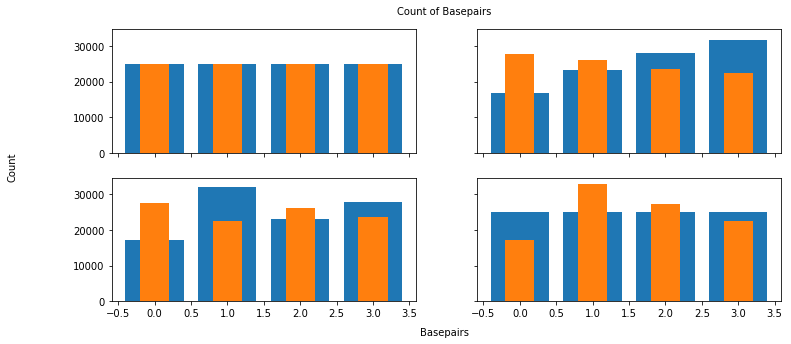

In [15]:
# plot the amount of each basepair in each sequence
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(12,5))
basepair_graph_comparison(same_one, same_two, .8, ax1)
basepair_graph_comparison(third_one, third_two, .8, ax2)
basepair_graph_comparison(two_thirds_one, two_thirds_two, .8, ax3)
basepair_graph_comparison(different_one, different_two, .8, ax4)
# set the title
fig.text(.51, .93, 'Count of Basepairs', ha='center', va='center')
# set x label
fig.text(0.51, 0.04, 'Basepairs', ha='center', va='center')
# set y label
fig.text(0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical')
plt.show()

There are multiple different distributions which will present a challenge for the network to process.

### X: Test the fittest individual:

The top performing network will now be tested against all of the created sequences. The mean squared error which will act as the similarity will be calculated and printed, as well as the output average from the network. The similarity will be plotted. If the model is fitting well then there shouldn't be much variation in the graph.

Output average: -0.42900345
Mean Squared Error: 0.9622287169216911 

Output average: -0.22168067
Mean Squared Error: 0.9432188389632742 

Output average: -0.23555617
Mean Squared Error: 0.9420756834274766 

Output average: -0.35597974
Mean Squared Error: 0.9321441807817868 



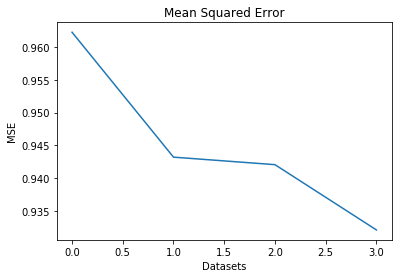

In [16]:
graph_output = []
graph_mse = []
# run the best network on the test data to test for consistency.
for x in range(4):
    y_pred = network_population[0].predict(comparison_tests[x])
    m_s_e = mse(similarity_tests[x], y_pred)
    graph_output.append(y_pred)
    graph_mse.append(m_s_e)
    print('Output average:', y_pred.mean())
    print('Mean Squared Error:', m_s_e, '\n')
    
#graph the mean squared error of the output on the test data
plt.plot(graph_mse)
plt.title('Mean Squared Error')
plt.xlabel('Datasets')
plt.ylabel('MSE')
plt.show()

"" some text on how the graph looks""

Finally, the ouput similarity will be graphed and examined for each set of test data. The output should reflect what is known about the data. The first set is completely the same, followed by 33% and 66 % the same, ending with sequences that are 100% disimilar.

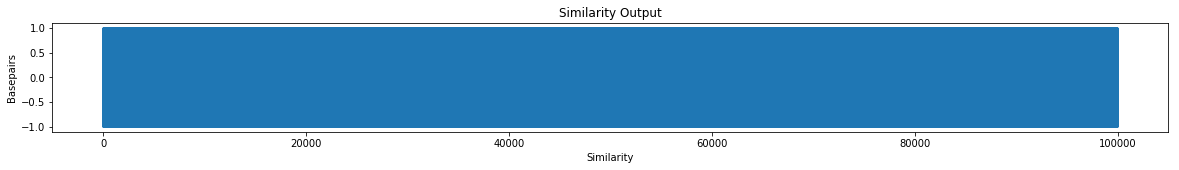

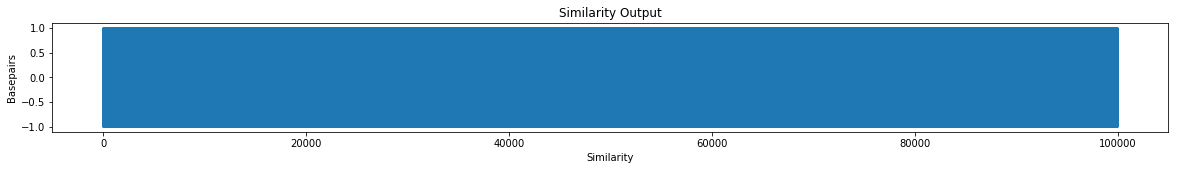

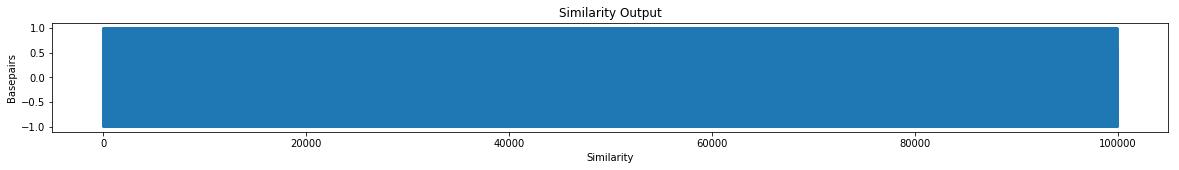

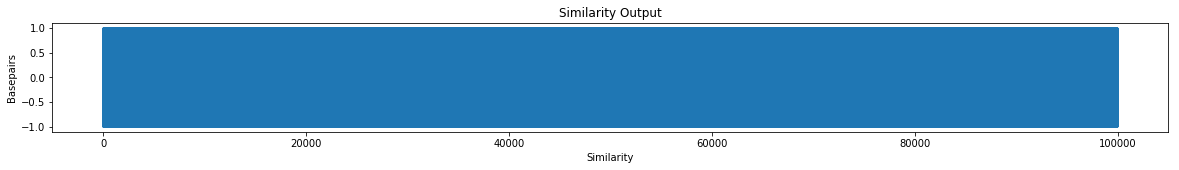

In [17]:
# plot the outputs for all of the networks
for x in graph_output:
    x = x.reshape(x.shape[0] * x.shape[1], 1)
    plt.figure(figsize=(20,2))
    plt.plot(x)
    plt.title('Similarity Output')
    plt.xlabel('Similarity')
    plt.ylabel('Basepairs')
    plt.show()

"" analysis of the graph ""

### XI: Importing Validation Data:

In order to validate the data, gene LOCUS NT_187301 will be passed into the top individual. The sequence is previously unseen and will be a great real world example to determine how the model is performing.

First the sequence will be imported from a text file as a string. The string will be cleaned using regex as before, removing the numbers, newlines and whitespaces.

The resulting basepairs will then be plotted in a bar graph to examine the distribution of basepairs.

Counter({'t': 56911, 'a': 53804, 'g': 34016, 'c': 32581})


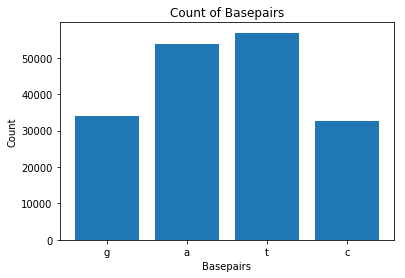

In [18]:
with open('dna2.txt', 'r') as myfile:
  dna2 = myfile.read()
validate_basepairs = dna2
validate_basepairs = re.sub(r'[0-9]([0-9])?([0-9])?([0-9])?([0-9])?([0-9])?', '', validate_basepairs)
validate_basepairs = re.sub(r'\n', '', validate_basepairs)
validate_basepairs = re.sub(r'\s+', '', validate_basepairs).strip()

validate_comparison, validate_similarity_array = create_dna_array(validate_basepairs[:170000], validate_basepairs[5000:175000], 50)

basepair_graph(validate_basepairs)

The distribution of basepairs hasn't been seen yet and will work great for validating the top individual.

### XII: Process and validate top individual:

The gene will now be processed and converted to an array and have its similarity calculated. The output of the top individual will be graphed below

Output average: -0.27548468
Mean Squared Error: 0.9539158439699872 



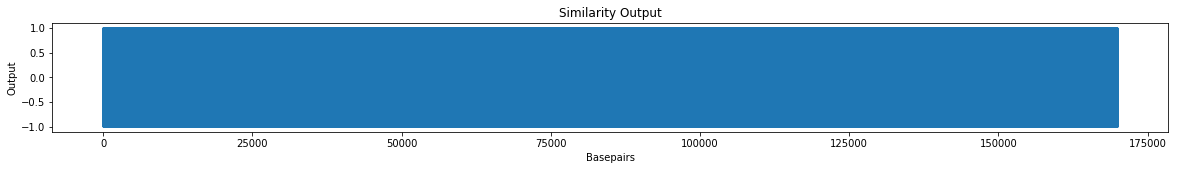

In [19]:
validate_comparison, validate_similarity_array = create_dna_array(validate_basepairs[:170000], validate_basepairs[5000:175000], 50)

y_pred = network_population[0].predict(validate_comparison)
m_s_e = mse(validate_similarity_array, y_pred)

print('Output average:', y_pred.mean())
print('Mean Squared Error:', m_s_e, '\n')

# plot the outputs for all of the networks
y_pred = y_pred.reshape(y_pred.shape[0] * y_pred.shape[1], 1)
plt.figure(figsize=(20,2))
plt.plot(y_pred)
plt.title('Similarity Output')
plt.xlabel('Basepairs')
plt.ylabel('Output')
plt.show()

"" some text on how the graph looks""


### XIII: Discussion and Conclusion:
